# 05wk-2: 합성곱신경망 (1)

최규빈  
2024-04-03

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/05wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [1]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-wjNGgd4gmQJbQ66NLjUC2y&si=dusDZAwGOJS9TOKJ >}}

# 2. Imports

In [4]:
import torch
import matplotlib.pyplot as plt
from fastai.data.all import *
import torchvision

# 3. Data: MNIST

`-` download data

In [124]:
path = untar_data(URLs.MNIST)

`-` training set

In [125]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0,X1])/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

`-` test set

In [126]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0,X1])/255
yy = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [127]:
X.shape,XX.shape,y.shape,yy.shape

# 4. CNN 예비학습

## A. 기존모형에 대한 불만

![](https://guebin.github.io/DL2022/posts/III.%20CNN/2022-10-18-7wk-2_files/figure-html/cell-8-output-1.svg)

`-` 왜 28 $\times$ 28 이미지를 784개의 벡터로 만든 다음에 모형을 돌려야
하는가?

`-` 기존에 개발된 모형이 회귀분석 기반으로 되어있어서 결국 회귀분석 틀에
짜 맞추어서 이미지자료를 분석하는 느낌

`-` observation의 차원은 $784$가 아니라 $1\times (28\times 28)$이 되어야
맞다.

## B. 새로운 아키텍처의 제시

`-` 예전 아키텍처들

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$
-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,256)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,256)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$
-   $\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,30)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,30)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 아키텍처들의 공통점?

-   $l_1$: 선형변환, feature를 뽑아내는 역할 (뻥튀기 혹은 요약)
-   $relu$: 뻥튀기된 feature에 비선형을 추가하여 표현력 극대화
-   $l_2$: 선형변환, 뻥튀기된 feature를 요약 하는 역할 (=데이터를
    요약하는 역할)

`-` 새로운 아키텍처

-   $conv$: feature를 뽑아내는 역할 (뻥튀기 혹은 요약) (2d ver $l_1$
    느낌)
-   $relu$:
-   $pooling$: 데이터를 요약하는 역할

## C. CONV 레이어 (선형변환의 2D 버전)

`-` 우선 연산하는 방법만 살펴보자.

**(예시1)**

In [46]:
torch.manual_seed(43052)
conv = torch.nn.Conv2d(1,1,(2,2)) # 입력1, 출력1, (2,2) window size
conv.weight.data, conv.bias.data

In [52]:
_X = torch.arange(0,4).reshape(1,1,2,2).float() # 2,2 흑백이미지. 
_X

In [53]:
(-0.1733)*0 + (-0.4235)*1 +\
(0.1802)*2 + (0.4668)*3 + 0.2037

In [54]:
conv(_X)

**(예시2) 잘하면 평균도 계산하겠다?**

In [50]:
conv.weight.data = torch.tensor([[[[1/4, 1/4],[1/4,1/4]]]])
conv.bias.data = torch.tensor([0.0])

In [51]:
conv(_X) , (0+1+2+3)/4

**(예시3) 이동평균?**

In [55]:
_X = torch.arange(0,25).float().reshape(1,1,5,5) 
_X

In [56]:
conv(_X)

**(예시4) window size가 증가한다면? (2d의 이동평균느낌)**

In [57]:
conv = torch.nn.Conv2d(1,1,(3,3)) # 입력1, 출력1, (3,3) window size
conv.bias.data = torch.tensor([0.0])
conv.weight.data = torch.tensor([[[[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]]])

In [58]:
_X,conv(_X)

In [59]:
(1+2+3+6+7+8+11+12+13)/9

**(예시5)** 2개의 이미지

In [89]:
conv = torch.nn.Conv2d(1,1,(3,3)) # 입력1, 출력1, (3,3) window size
conv.bias.data = torch.tensor([0.0])
conv.weight.data = torch.tensor([[[[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]]])

In [90]:
_X = torch.arange(0,50).float().reshape(2,1,5,5) 
_X

In [91]:
conv(_X)

**(예시6) 피처뻥튀기**

In [61]:
_X = torch.tensor([1.0,1.0,1.0,1.0]).reshape(1,1,2,2)
_X

In [62]:
conv = torch.nn.Conv2d(1,8,(2,2))
conv.weight.data.shape,conv.bias.data.shape

In [63]:
conv(_X).reshape(-1)

In [64]:
torch.sum(conv.weight.data[0,...])+conv.bias.data[0],\
torch.sum(conv.weight.data[1,...])+conv.bias.data[1]

결국 아래를 계산한다는 의미

In [73]:
torch.sum(conv.weight.data,axis=(2,3)).reshape(-1) + conv.bias.data

In [74]:
conv(_X).reshape(-1)

## D. ReLU (2d)

In [92]:
_X = torch.randn(25).reshape(1,1,5,5)
_X

In [93]:
a1=torch.nn.ReLU()

In [94]:
a1(_X)

## E. Maxpooling 레이어

In [95]:
_maxpooling = torch.nn.MaxPool2d((2,2))

In [96]:
_X = torch.arange(16).float().reshape(1,1,4,4) 

In [97]:
_X, _maxpooling(_X) 

In [98]:
_X = torch.arange(25).float().reshape(1,1,5,5) 

In [99]:
_X, _maxpooling(_X) 

In [100]:
_X = torch.arange(36).float().reshape(1,6,6) 

In [102]:
_X, _maxpooling(_X)

# 5. MNIST(CPU)

In [106]:
X.shape

## A. Conv2d

In [107]:
c1 = torch.nn.Conv2d(1,16,(5,5))
print(X.shape)
print(c1(X).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])

## B. ReLU

In [108]:
a1 = torch.nn.ReLU()
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])

## C. MaxPool2D

In [109]:
m1 =  torch.nn.MaxPool2d((2,2)) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])

## D. 적당히 마무리하고 시그모이드 태우자

`-` 펼치자.

(방법1)

In [110]:
m1(a1(c1(X))).reshape(-1,2304).shape

In [111]:
16*12*12 

(방법2)

In [112]:
flttn = torch.nn.Flatten()

In [113]:
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])

`-` 2304 $\to$ 1 로 차원축소하는 선형레이어를 설계

In [114]:
l1 = torch.nn.Linear(in_features=2304,out_features=1) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])

`-` 시그모이드

In [115]:
a2 = torch.nn.Sigmoid()

In [116]:
l1 = torch.nn.Linear(in_features=2304,out_features=1) 
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)
print(a1(l1(flttn(m1(a1(c1(X)))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])
torch.Size([12665, 1])

## E. 학습

`-` 네트워크 설계

In [207]:
net = torch.nn.Sequential(
    c1, # 2d: 컨볼루션(선형변환), 피처 뻥튀기 
    a1, # 2d: 렐루(비선형변환)
    m1, # 2d: 맥스풀링: 데이터요약
    flttn, # 2d->1d 
    l1, # 1d: 선형변환
    a2 # 1d: 시그모이드(비선형변환) 
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
for epoc in range(50): 
    ## 1
    yhat = net(X) 
    ## 2
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward()
    ## 4
    optimizr.step()
    optimizr.zero_grad()

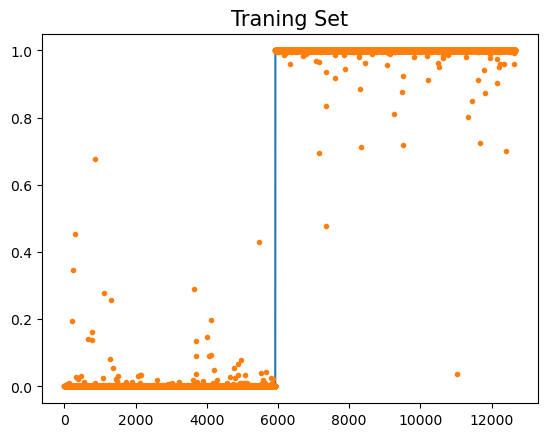

In [208]:
plt.plot(y)
plt.plot(net(X).data,'.')
plt.title('Traning Set',size=15)

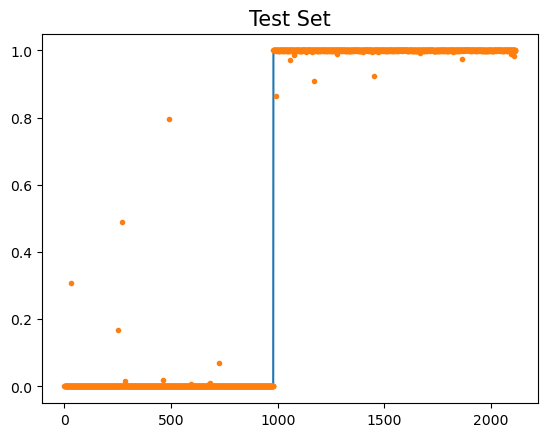

In [209]:
plt.plot(yy)
plt.plot(net(XX).data,'.')
plt.title('Test Set',size=15)

In [144]:
[np.prod(list(para.shape)) for para in net.parameters()]

# 6. MNIST (GPU)

In [225]:
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=128)
#--#
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#--#
net.to("cuda:0")
for epoc in range(5): 
    for xi,yi in dl: 
        ## 1
        netout = net(xi.to("cuda:0")) 
        ## 2
        loss = loss_fn(netout,yi.to("cuda:0")) 
        ## 3
        loss.backward()
        ## 4
        optimizr.step()
        optimizr.zero_grad()

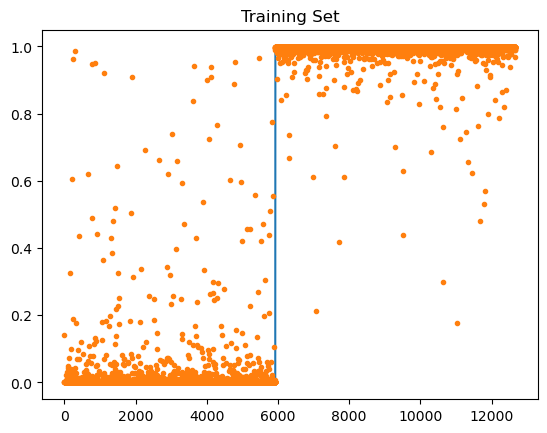

In [226]:
net.to("cpu")
plt.plot(y)
plt.plot(net(X).data,'.')
plt.title("Training Set")

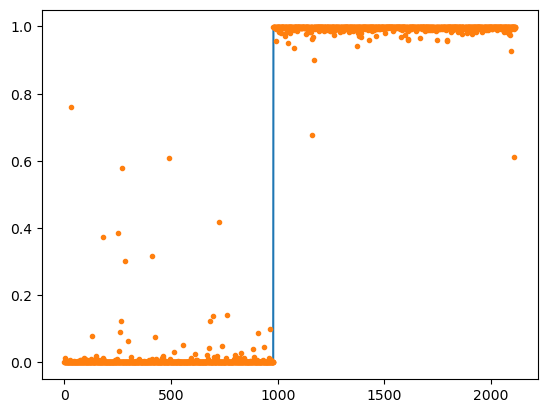

In [227]:
#net.to("cpu")
plt.plot(yy)
plt.plot(net(XX).data,'.')

# A1. 자잘한 용어 정리 ($\star$)

## A. 지도학습

`-` 우리가 수업에서 다루는 데이터는 주로 아래와 같은 느낌이다.

1.  데이터는 $(X,y)$의 형태로 정리되어 있다.

2.  $y$는 우리가 관심이 있는 변수이다. 즉 우리는 $y$를 적절하게 추정하는
    것에 관심이 있다.

3.  $X$는 $y$를 추정하기 위해 필요한 정보이다.

|  $X$ = 설명변수 = 독립변수   | $y$ = 반응변수 = 종속변수  |     비고     |     순서     |           예시           |
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
|            이미지            |          카테고리          | 합성곱신경망 |   상관없음   |  개/고양이 이미지 구분   |
|         유저,아이템          |            평점            |  추천시스템  |   상관없음   |    넷플릭스 영화추천     |
|     과거~오늘까지의주가      |          내일주가          |  순환신경망  | 순서상관있음 |         주가예측         |
| 처음 $m$개의 단어(혹은 문장) | 이후 1개의 단어(혹은 문장) |  순환신경망  | 순서상관있음 |     챗봇, 텍스트생성     |
| 처음 $m$개의 단어(혹은 문장) |          카테고리          |  순환신경망  | 순서상관있음 | 영화리뷰 텍스트 감정분류 |

`-` 이러한 문제상황, 즉 $(X,y)$가 주어졌을때 $X \to y$를 추정하는 문제를
supervised learning 이라한다.

## B. 모델이란?

> 모델이란 단어는 제 발작버튼이었어요..

`-` 통계학에서 모델은 y와 x의 관계를 의미하며 오차항의 설계를 포함하는
개념이다. 이는 통계학이 “데이터 = 정보 + 오차”의 관점을 유지하기
때문이다. 따라서 통계학에서 모델링이란

$$y_i = net(x_i) + \epsilon_i$$

에서 (1) 적절한 함수 $net$를 선택하는 일 (2) 적절한 오차항 $\epsilon_i$
을 설계하는일 모두를 포함한다.

`-` 딥러닝 혹은 머신러닝에서 모델은 단순히

$$y_i \approx net(x_i)$$

를 의미하는 경우가 많다. 즉 “model=net”라고 생각해도 무방하다. 이 경우
“모델링”이란 단순히 적절한 $net$을 설계하는 것만을 의미할 경우가 많다.

`-` 그래서 생긴일

-   통계학교재 특: 분류문제와 회귀문제를 엄밀하게 구분하지 않는다. 사실
    오차항만 다를뿐이지 크게보면 같은 회귀모형이라는 관점이다. 그래서
    일반화선형모형(GLM)이라는 용어를 쓴다.
-   머신러닝/딥러닝교재 특: 회귀문제와 분류문제를 구분해서 설명한다.
    (표도 만듦) 이는 오차항에 대한 기술을 모호하게 하여 생기는 현상이다.

## C. 학습이란?

`-` 학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
“규칙” 혹은 “원리”를 찾는 것이다.

-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “맵핑”을 찾는 것이다.
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “함수”을 찾는 것이다. 즉 $y\approx f(X)$가 되도록 만드는 $f$를 잘
    찾는 것이다. (이 경우 “함수를 추정한다”라고 표현)
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한
    “모델” 혹은 “모형”을 찾는 것이다. 즉 $y\approx model(X)$가 되도록
    만드는 $model$을 잘 찾는 것이다. (이 경우 “모형을 학습시킨다”라고
    표현)
-   **학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는
    어떠한 “네트워크”을 찾는 것이다. 즉 $y\approx net(X)$가 되도록
    만드는 $net$을 잘 찾는 것이다. (이 경우 “네트워크를 학습시킨다”라고
    표현)**

`-` prediction이란 학습과정에서 찾은 “규칙” 혹은 “원리”를 $X$에 적용하여
$\hat{y}$을 구하는 과정이다. 학습과정에서 찾은 규칙 혹은 원리는
$f$,$model$,$net$ 으로 생각가능한데 이에 따르면 아래가 성립한다.

-   $\hat{y} = f(X)$
-   $\hat{y} = model(X)$
-   $\hat{y} = net(X)$

## D. $\hat{y}$를 부르는 다양한 이름

`-` $\hat{y}$는 $X$가 주어진 자료에 있는 값인지 아니면 새로운 값 인지에
따라 지칭하는 이름이 미묘하게 다르다.

1.  $X \in data$: $\hat{y}=net(X)$ 는 predicted value, fitted value 라고
    부른다.

2.  $X \notin data$: $\hat{y}=net(X)$ 는 predicted value, predicted
    value with new data 라고 부른다.

`-` 경우1은 “$loss$ = $y$ 와 $\hat{y}$ 의 차이” 를 정의할 수 있으나
경우2는 그렇지 않다.

## E. 다양한 코드들

`-` 파이썬 코드..

``` python
#Python
predictor.fit(X,y) # autogluon 에서 "학습"을 의미하는 과정
model.fit(X,y) # sklearn 에서 "학습"을 의미하는 과정
learner.learn() # fastai 에서 "학습"을 의미하는 과정
learner.fine_tune(1) # fastai 에서 "부분학습"을 의미하는 과정
learner.predict(cat1) # fastai 에서 "예측"을 의미하는 과정 
model.fit(x, y, batch_size=32, epochs=10) # keras에서 "학습"을 의미하는 과정
model.predict(test_img) # keras에서 "예측"을 의미하는 과정 
```

`-` R 코드..

``` r
# R
ols <- lm(y~x) # 선형회귀분석에서 학습을 의미하는 함수
ols$fitted.values # 선형회귀분석에서 yhat을 출력 
predict(ols, newdata=test) # 선형회귀분석에서 test에 대한 예측값을 출력하는 함수
ols$coef # 선형회귀분석에서 weight를 확인하는 방법
```

# A2. 참고자료들

`-` 케라스/텐서플로우: <https://guebin.github.io/STBDA2022/>

`-` 상속:
<https://guebin.github.io/PP2023/posts/03_Class/2023-06-12-15wk-1.html>

`-` sklearn/autogluon: <https://guebin.github.io/MP2023/>

`-` 리눅스관련: <https://guebin.github.io/DSTBX2024/> – 자료 부실함..
강의영상 없는것 많음..